# Assignment 8

#### 1. 复习上课内容

#### 2.理论题

##### 1.  What is semi-supervised learning ?
##### 半监督学习将大量的无类标签的样例加入到有限的有类标签的样本中一起训练来进行学习，期望能对学习性能起到改进的作用，避免了数据和资源的浪费，同时解决了SL的 模型泛化能力不强和UL的模型不精确等问题。

##### 2. What is GMM ?
##### 混合高斯模型本质就是融合多个单高斯模型，来使得模型更加复杂，从而产生更复杂的样本。

##### 3. What are the diffreences between seed k-means and constrained k-means ?
##### seed k-means，利用有标签的数据初始化聚类中心点，label data仅用作初始化，之后会重新训练，分类有可能发生改变。
##### constrained k-means，利用有标签的数据初始化聚类中心点，label data仍会使用但是分类要保持不变

##### 4. Please briefly describe what are self-training and co-training ? 
##### 数据A和B，其中A是已标注的数据，即带Label的；而B是未标注数据
##### Self-Training:从已标注数据A中训练一个分类模型M，用该模型对B进行预测，将预测结果中置信度高的K个样本，连同它们的Label加入训练数据A。
##### 从（X-1, Y-1），（X-2, Y-2）分别训练得到两个个分类模型F-1，F-2，分别使用F-1与F-2对未标注数据进行预测，将F-1所预测的前K个置信度最高的样本加入F-2的训练数据集，将F-2所预测的前K个置信度最高的样本加入F-1的训练数据集

##### 5. What is active learning ?
##### 为了尽可能地减小训练集及标注成本，在机器学习领域中，提出主动学习（active learning）方法，优化分类模型。主动算法可以主动地进行标注，将一些经过筛选的数据提交给专家进行标注

#### 3.实践题

Titanic: Machine Learning from Disaster

Data Source :https://www.kaggle.com/c/titanic/data

####  In this assignment, you have to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

低： 完成。

高：准确率 95% 以上。

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
sns.set_style('whitegrid')
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### passengerId:乘客ID
#### survived:是否被救获
#### Pclass:乘客等级（舱位等级分为1/2/3等）
#### Name:乘客姓名
#### Sex:乘客性别
#### Age:乘客年龄
#### SibSp:siblings&spoused,该乘客在船上的堂兄弟妹/配偶人数
#### Parch:该乘客在船上的父母/孩子人数
#### Ticket:船票信息 
#### Fare:票价
#### Cabin:客舱
#### Embarked:登船港口
    出发地点：S=英国南安普顿Southampton
    途径地点1：C=法国 瑟堡市Cherbourg
    途径地点2：Q=爱尔兰 昆士敦Queenstown

In [3]:
train_data.info()
print('*'*50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         41

#### 由info信息可知Age、Cabin、Embarked、Fare几个特征存在缺失值。

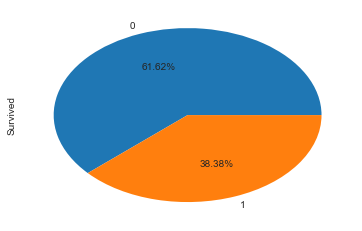

In [4]:
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')
# Series.value_counts() //统计重复重现的数据的个数。返回以数据作为key，以重复个数为value的对象。

#### 缺失值处理
#### (1)如果数据集很多，但有很少的缺失值，可以删掉带缺失值的行
#### (2)如果该属性相对学习来说不是很重要，可以对缺失值赋均值或者众数。

In [5]:
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

D:\Anaconda\anzhuang\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
# 标称属性，可以赋一个代表缺失的值，比如‘U0’。因为缺失本身也可能代表着一些隐含信息。
train_data['Cabin'] = train_data.Cabin.fillna('U0')

In [10]:
from sklearn.ensemble import RandomForestRegressor
age_df = train_data[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df.head()

,Age,Survived,Fare,Parch,SibSp,Pclass
0,22.0,0,7.2500,0,1,3
1,38.0,1,71.2833,0,1,1
2,26.0,1,7.9250,0,0,3
3,35.0,1,53.1000,0,1,1
4,35.0,0,8.0500,0,0,3


In [11]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Age         714 non-null float64
Survived    891 non-null int64
Fare        891 non-null float64
Parch       891 non-null int64
SibSp       891 non-null int64
Pclass      891 non-null int64
dtypes: float64(2), int64(4)
memory usage: 41.8 KB


In [12]:
age_df_notnull = age_df[train_data['Age'].notnull()]
print(age_df_notnull.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 6 columns):
Age         714 non-null float64
Survived    714 non-null int64
Fare        714 non-null float64
Parch       714 non-null int64
SibSp       714 non-null int64
Pclass      714 non-null int64
dtypes: float64(2), int64(4)
memory usage: 39.0 KB
None


In [13]:
age_df_isnull = age_df[train_data['Age'].isnull()]
print(age_df_isnull.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 5 to 888
Data columns (total 6 columns):
Age         0 non-null float64
Survived    177 non-null int64
Fare        177 non-null float64
Parch       177 non-null int64
SibSp       177 non-null int64
Pclass      177 non-null int64
dtypes: float64(2), int64(4)
memory usage: 9.7 KB
None


In [14]:
# 随机森林train data set
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]

In [15]:
print(age_df_notnull.isnull().any())

Age         False
Survived    False
Fare        False
Parch       False
SibSp       False
Pclass      False
dtype: bool


In [16]:
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1,oob_score=True)
RFR.fit(X,Y)
print(RFR.oob_score_)

0.2359318074487985


In [17]:
train_data.loc[train_data['Age'].isnull(),['Age']]

,Age
5,NaN
17,NaN
19,NaN
26,NaN
28,NaN
29,NaN
31,NaN
32,NaN
36,NaN
42,NaN


In [18]:
predcit_age = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(),['Age']]=predcit_age

In [19]:
# 缺失数据处理后的DataFram
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [20]:
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [30]:
train_data[['Sex','Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


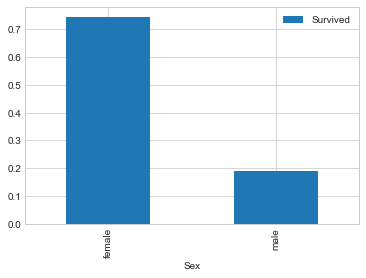

In [21]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

In [24]:
train_data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64

In [27]:
train_data[['Pclass','Survived']].groupby(['Pclass']).count()

,Survived
Pclass,
1,216
2,184
3,491


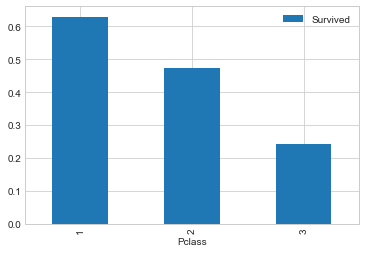

In [32]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

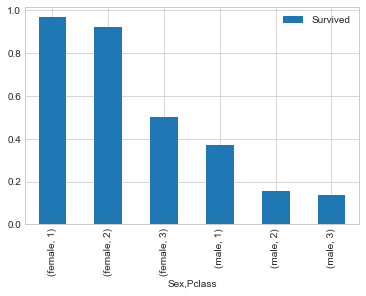

In [33]:
train_data[['Sex','Pclass','Survived']].groupby(['Sex','Pclass']).mean().plot.bar()

D:\Anaconda\anzhuang\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


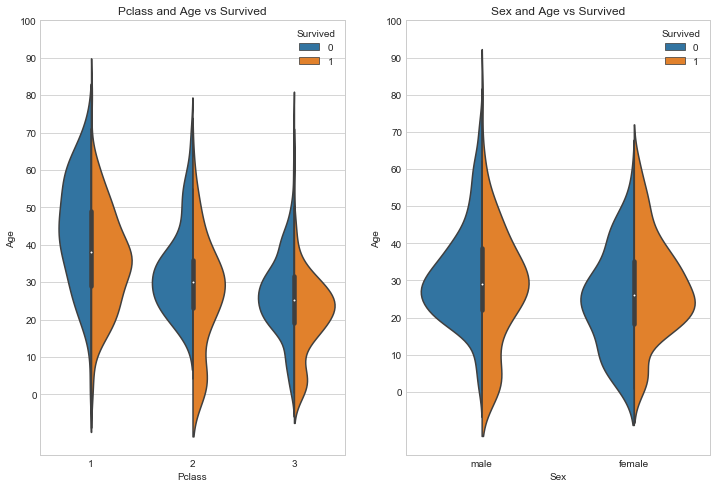

In [38]:
subplot,axes = plt.subplots(1,2,figsize = (12,8))
sns.violinplot('Pclass','Age',hue='Survived',data=train_data,split=True,ax=axes[0])
axes[0].set_title('Pclass and Age vs Survived')
axes[0].set_yticks(range(0, 110, 10))
                  
# subplot,axes = plt.subplots(1,2,figsize = (12,8))
sns.violinplot('Sex','Age',hue='Survived',data=train_data,split=True,ax=axes[1])
axes[1].set_title('Sex and Age vs Survived')
axes[1].set_yticks(range(0, 110, 10))
plt.show()

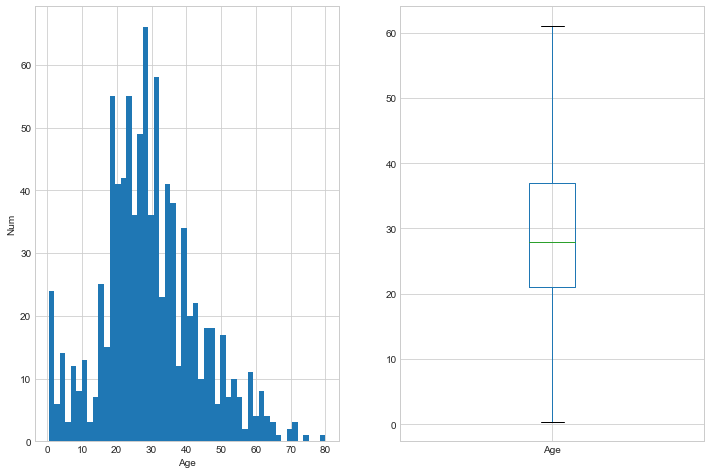

In [49]:
plt.figure(figsize=(12,8))
plt.subplot(121)
train_data['Age'].hist(bins=50)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot(column='Age',showfliers=False)


D:\Anaconda\anzhuang\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


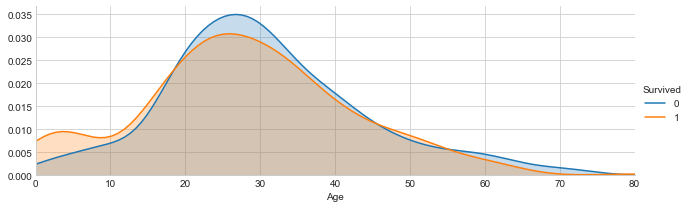

In [52]:
# 不同年龄下的生存和非生存的分布情况：
facet = sns.FacetGrid(train_data,hue='Survived',aspect=3)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train_data['Age'].max()))
facet.add_legend()

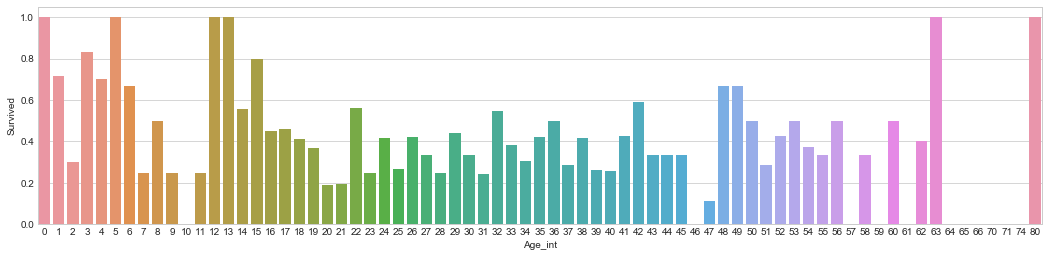

In [68]:
plt.figure(figsize=(18,4))
train_data['Age_int'] = train_data['Age'].astype('int')
average_age = train_data[['Age_int', 'Survived']].groupby(['Age_int'],as_index=False).mean()
sns.barplot(x = 'Age_int', y = 'Survived',data=average_age)

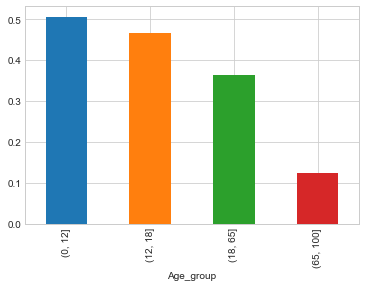

In [69]:
bins = [0, 12, 18, 65, 100]
train_data['Age_group'] = pd.cut(train_data['Age'],bins)# 将每个Age划分到bins的区间
group_byage = train_data.groupby('Age_group')['Survived'].mean()
group_byage.plot(kind='bar')

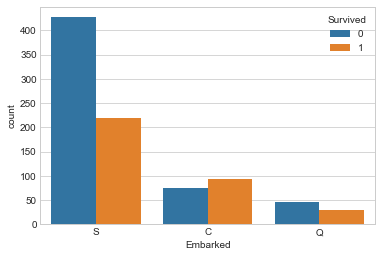

In [70]:
# 港口和存活与否的关系 Embarked
sns.countplot('Embarked',hue = 'Survived', data = train_data)

D:\Anaconda\anzhuang\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


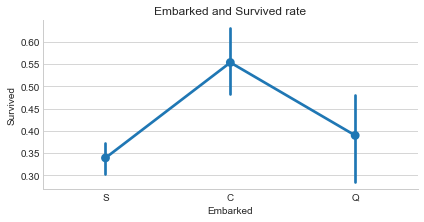

In [71]:
sns.factorplot('Embarked', 'Survived', data=train_data, size=3, aspect=2)
plt.title('Embarked and Survived rate')
plt.show()

In [72]:
embark_dummy = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embark_dummy)
train_data.drop(['Embarked'], axis=1,inplace=True)

In [73]:
embark_dummies = train_data[['S', 'C', 'Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [2]:
train_df_org = pd.read_csv('./train.csv')
test_df_org = pd.read_csv('./test.csv')
test_df_org['Survived'] = 0
combined_train_test = train_df_org.append(test_df_org)
PassengerId = test_df_org['PassengerId']
combined_train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


In [3]:
# Embarked”项的缺失值不多，以众数来填充
combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0],inplace = True)

In [4]:
# 为了后面的特征分析，这里我们将 Embarked 特征进行facrorizing
combined_train_test['Embarked'] = pd.factorize(combined_train_test['Embarked'])[0]

# 使用 pd.get_dummies 获取one-hot 编码
emb_dummies_df = pd.get_dummies(combined_train_test['Embarked'], prefix=combined_train_test[['Embarked']].columns[0])
combined_train_test = pd.concat([combined_train_test, emb_dummies_df], axis=1)

In [5]:
combined_train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Embarked_0,Embarked_1,Embarked_2
0,22.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,1,0,0
1,38.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,0,1,0
2,26.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,1,0,0
3,35.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,1,0,0
4,35.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,1,0,0


In [14]:
combined_train_test[['Sex']].columns[0]

'Sex'

In [15]:
# 为了后面的特征分析，这里我们也将 Sex 特征进行facrorizing
combined_train_test['Sex'] = pd.factorize(combined_train_test['Sex'])[0]
# 对Sex也进行one-hot编码，也就是dummy处理
sex_dummies_df = pd.get_dummies(combined_train_test['Sex'], prefix=combined_train_test[['Sex']].columns[0])
combined_train_test = pd.concat([combined_train_test, sex_dummies_df], axis=1)

In [16]:
dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer')

{'Capt': 'Officer',
 'Col': 'Officer',
 'Dr': 'Officer',
 'Major': 'Officer',
 'Rev': 'Officer'}

In [17]:
# 从名字中提取各种称呼
combined_train_test['Title'] = combined_train_test['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

combined_train_test['Title'] = combined_train_test['Title'].map(title_Dict)

In [18]:
# 为了后面的特征分析，这里我们也将 Title 特征进行facrorizing
combined_train_test['Title'] = pd.factorize(combined_train_test['Title'])[0]

title_dummies_df = pd.get_dummies(combined_train_test['Title'], prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test, title_dummies_df], axis=1)
combined_train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_2,Sex_0,Sex_1,Title,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5
0,22.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,...,0,1,0,0,1,0,0,0,0,0
1,38.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,...,0,0,1,1,0,1,0,0,0,0
2,26.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,...,0,0,1,2,0,0,1,0,0,0
3,35.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,...,0,0,1,1,0,1,0,0,0,0
4,35.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,...,0,1,0,0,1,0,0,0,0,0


In [19]:
combined_train_test['Name_length'] = combined_train_test['Name'].apply(len)

In [20]:
combined_train_test['Fare'] = combined_train_test[['Fare']].fillna(combined_train_test.groupby('Pclass').transform(np.mean))

In [22]:
 combined_train_test['Fare'].head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

In [23]:
# 通过对Ticket数据的分析，我们可以看到部分票号数据有重复，同时结合亲属人数及名字的数据，和票价船舱等级对比，
# 我们可以知道购买的票中有家庭票和团体票，所以我们需要将团体票的票价分配到每个人的头上。
combined_train_test['Group_Ticket'] = combined_train_test['Fare'].groupby(by=combined_train_test['Ticket']).transform('count')
combined_train_test['Fare'] = combined_train_test['Fare'] / combined_train_test['Group_Ticket']
combined_train_test.drop(['Group_Ticket'], axis=1, inplace=True)
# 使用binning给票价分等级
combined_train_test['Fare_bin'] = pd.qcut(combined_train_test['Fare'], 5)
combined_train_test['Fare_bin_id'] = pd.factorize(combined_train_test['Fare_bin'])[0]

fare_bin_dummies_df = pd.get_dummies(combined_train_test['Fare_bin_id']).rename(columns=lambda x: 'Fare_' + str(x))
combined_train_test = pd.concat([combined_train_test, fare_bin_dummies_df], axis=1)
combined_train_test.drop(['Fare_bin'], axis=1, inplace=True)


In [25]:
combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean()

Pclass
1    33.910500
2    11.411010
3     7.337571
Name: Fare, dtype: float64

In [24]:
# LabelEncoder可以将标签分配一个0—n_classes-1之间的编码
from sklearn.preprocessing import LabelEncoder

# 建立PClass Fare Category
def pclass_fare_category(df, pclass1_mean_fare, pclass2_mean_fare, pclass3_mean_fare):
    if df['Pclass'] == 1:
        if df['Fare'] <= pclass1_mean_fare:
            return 'Pclass1_Low'
        else:
            return 'Pclass1_High'
    elif df['Pclass'] == 2:
        if df['Fare'] <= pclass2_mean_fare:
            return 'Pclass2_Low'
        else:
            return 'Pclass2_High'
    elif df['Pclass'] == 3:
        if df['Fare'] <= pclass3_mean_fare:
            return 'Pclass3_Low'
        else:
            return 'Pclass3_High'
        
Pclass1_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([1]).values[0]
Pclass2_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([2]).values[0]
Pclass3_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([3]).values[0]

# 建立Pclass_Fare Category
combined_train_test['Pclass_Fare_Category'] = combined_train_test.apply(pclass_fare_category, args=(
    Pclass1_mean_fare, Pclass2_mean_fare, Pclass3_mean_fare), axis=1)
pclass_level = LabelEncoder()

# 给每一项添加标签
pclass_level.fit(np.array(
    ['Pclass1_Low', 'Pclass1_High', 'Pclass2_Low', 'Pclass2_High', 'Pclass3_Low', 'Pclass3_High']))

# 转换成数值
combined_train_test['Pclass_Fare_Category'] = pclass_level.transform(combined_train_test['Pclass_Fare_Category'])

# dummy 转换
pclass_dummies_df = pd.get_dummies(combined_train_test['Pclass_Fare_Category']).rename(columns=lambda x: 'Pclass_' + str(x))
combined_train_test = pd.concat([combined_train_test, pclass_dummies_df], axis=1)


In [26]:
combined_train_test['Pclass'] = pd.factorize(combined_train_test['Pclass'])[0]
combined_train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Fare_2,Fare_3,Fare_4,Pclass_Fare_Category,Pclass_0,Pclass_1,Pclass_2,Pclass_3,Pclass_4,Pclass_5
0,22.0,NaN,0,7.25000,"Braund, Mr. Owen Harris",0,1,0,0,1,...,0,0,0,5,0,0,0,0,0,1
1,38.0,C85,1,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,...,0,0,0,0,1,0,0,0,0,0
2,26.0,NaN,0,7.92500,"Heikkinen, Miss. Laina",0,3,0,1,0,...,1,0,0,4,0,0,0,0,1,0
3,35.0,C123,0,26.55000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,...,0,0,0,1,0,1,0,0,0,0
4,35.0,NaN,0,8.05000,"Allen, Mr. William Henry",0,5,0,0,0,...,1,0,0,4,0,0,0,0,1,0


In [27]:
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'

combined_train_test['Family_Size'] = combined_train_test['Parch'] + combined_train_test['SibSp'] + 1
combined_train_test['Family_Size_Category'] = combined_train_test['Family_Size'].map(family_size_category)

le_family = LabelEncoder()
le_family.fit(np.array(['Single', 'Small_Family', 'Large_Family']))
combined_train_test['Family_Size_Category'] = le_family.transform(combined_train_test['Family_Size_Category'])

family_size_dummies_df = pd.get_dummies(combined_train_test['Family_Size_Category'],
                                        prefix=combined_train_test[['Family_Size_Category']].columns[0])
combined_train_test = pd.concat([combined_train_test, family_size_dummies_df], axis=1)


In [29]:
missing_age_df = pd.DataFrame(combined_train_test[
    ['Age', 'Embarked', 'Sex', 'Title', 'Name_length', 'Family_Size', 'Family_Size_Category','Fare', 'Fare_bin_id', 'Pclass']])

missing_age_train = missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test = missing_age_df[missing_age_df['Age'].isnull()]
missing_age_test.head()

,Age,Embarked,Sex,Title,Name_length,Family_Size,Family_Size_Category,Fare,Fare_bin_id,Pclass
5,NaN,2,0,0,16,1,1,8.4583,2,0
17,NaN,0,0,0,28,1,1,13.0000,3,2
19,NaN,1,1,1,23,1,1,7.2250,4,0
26,NaN,1,0,0,23,1,1,7.2250,4,0
28,NaN,2,1,2,29,1,1,7.8792,0,0


In [30]:
from sklearn import ensemble
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def fill_missing_age(missing_age_train, missing_age_test):
    missing_age_X_train = missing_age_train.drop(['Age'], axis=1)
    missing_age_Y_train = missing_age_train['Age']
    missing_age_X_test = missing_age_test.drop(['Age'], axis=1)

    # model 1  gbm
    gbm_reg = GradientBoostingRegressor(random_state=42)
    gbm_reg_param_grid = {'n_estimators': [2000], 'max_depth': [4], 'learning_rate': [0.01], 'max_features': [3]}
    gbm_reg_grid = model_selection.GridSearchCV(gbm_reg, gbm_reg_param_grid, cv=10, n_jobs=25, verbose=1, scoring='neg_mean_squared_error')
    gbm_reg_grid.fit(missing_age_X_train, missing_age_Y_train)
    print('Age feature Best GB Params:' + str(gbm_reg_grid.best_params_))
    print('Age feature Best GB Score:' + str(gbm_reg_grid.best_score_))
    print('GB Train Error for "Age" Feature Regressor:' + str(gbm_reg_grid.score(missing_age_X_train, missing_age_Y_train)))
    missing_age_test.loc[:, 'Age_GB'] = gbm_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_GB'][:4])
    
    # model 2 rf
    rf_reg = RandomForestRegressor()
    rf_reg_param_grid = {'n_estimators': [200], 'max_depth': [5], 'random_state': [0]}
    rf_reg_grid = model_selection.GridSearchCV(rf_reg, rf_reg_param_grid, cv=10, n_jobs=25, verbose=1, scoring='neg_mean_squared_error')
    rf_reg_grid.fit(missing_age_X_train, missing_age_Y_train)
    print('Age feature Best RF Params:' + str(rf_reg_grid.best_params_))
    print('Age feature Best RF Score:' + str(rf_reg_grid.best_score_))
    print('RF Train Error for "Age" Feature Regressor' + str(rf_reg_grid.score(missing_age_X_train, missing_age_Y_train)))
    missing_age_test.loc[:, 'Age_RF'] = rf_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_RF'][:4])

    # two models merge
    print('shape1', missing_age_test['Age'].shape, missing_age_test[['Age_GB', 'Age_RF']].mode(axis=1).shape)
    # missing_age_test['Age'] = missing_age_test[['Age_GB', 'Age_LR']].mode(axis=1)

    missing_age_test.loc[:, 'Age'] = np.mean([missing_age_test['Age_GB'], missing_age_test['Age_RF']])
    print(missing_age_test['Age'][:4])

    missing_age_test.drop(['Age_GB', 'Age_RF'], axis=1, inplace=True)

    return missing_age_test

D:\Anaconda\anzhuang\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [31]:
combined_train_test.loc[(combined_train_test.Age.isnull()), 'Age'] = fill_missing_age(missing_age_train, missing_age_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=25)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=25)]: Done  10 out of  10 | elapsed:   15.1s finished


Age feature Best GB Params:{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 3, 'n_estimators': 2000}
Age feature Best GB Score:-130.2956775989383
GB Train Error for "Age" Feature Regressor:-64.65669617233556


D:\Anaconda\anzhuang\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\anzhuang\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


5     35.773942
17    31.489153
19    34.113840
26    28.621281
Name: Age_GB, dtype: float64
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=25)]: Done   5 out of  10 | elapsed:    8.2s remaining:    8.2s
[Parallel(n_jobs=25)]: Done  10 out of  10 | elapsed:   13.6s finished


Age feature Best RF Params:{'max_depth': 5, 'n_estimators': 200, 'random_state': 0}
Age feature Best RF Score:-119.09495605170706
RF Train Error for "Age" Feature Regressor-96.06031484477619


D:\Anaconda\anzhuang\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\anzhuang\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


5     33.459421
17    33.076798
19    34.855942
26    28.146718
Name: Age_RF, dtype: float64
shape1 (263,) (263, 2)
5     30.000675
17    30.000675
19    30.000675
26    30.000675
Name: Age, dtype: float64


D:\Anaconda\anzhuang\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket'].str.split().str[0]
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket_Letter'].apply(lambda x: 'U0' if x.isnumeric() else x)

# 如果要提取数字信息，则也可以这样做，现在我们对数字票单纯地分为一类。
# combined_train_test['Ticket_Number'] = combined_train_test['Ticket'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# combined_train_test['Ticket_Number'].fillna(0, inplace=True)

# 将 Ticket_Letter factorize
combined_train_test['Ticket_Letter'] = pd.factorize(combined_train_test['Ticket_Letter'])[0]


In [33]:
combined_train_test.loc[combined_train_test.Cabin.isnull(), 'Cabin'] = 'U0'
combined_train_test['Cabin'] = combined_train_test['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)

In [34]:
Correlation = pd.DataFrame(combined_train_test[
    ['Embarked', 'Sex', 'Title', 'Name_length', 'Family_Size', 'Family_Size_Category','Fare', 'Fare_bin_id', 'Pclass', 
     'Pclass_Fare_Category', 'Age', 'Ticket_Letter', 'Cabin']])

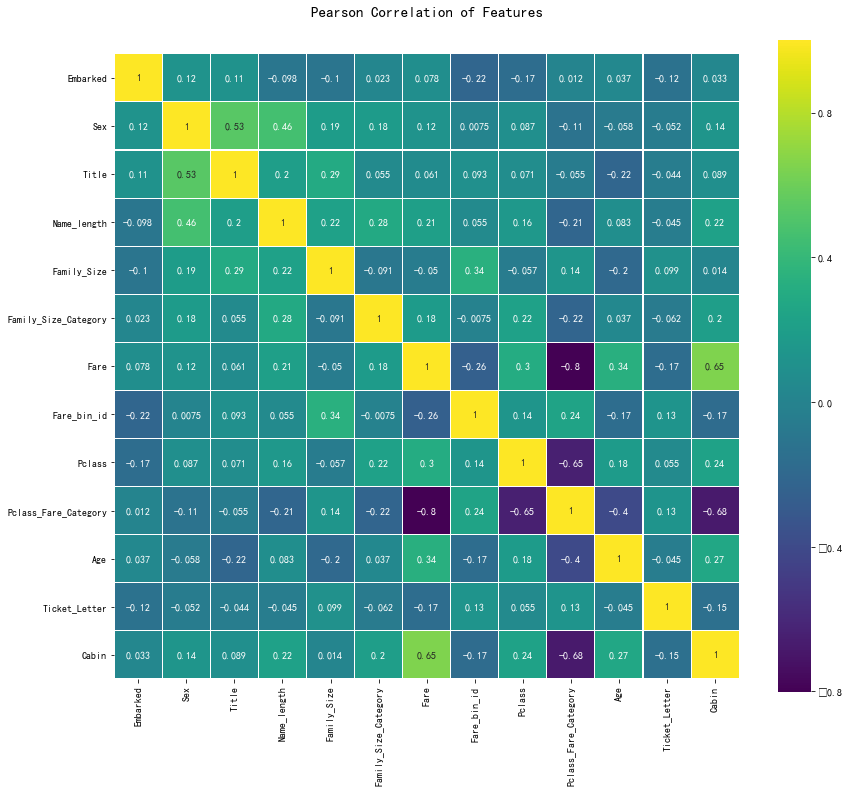

In [23]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [35]:
# 正则化
from sklearn import preprocessing
scale_age_fare = preprocessing.StandardScaler().fit(combined_train_test[['Age','Fare', 'Name_length']])
combined_train_test[['Age','Fare', 'Name_length']] = scale_age_fare.transform(combined_train_test[['Age','Fare', 'Name_length']])

In [36]:
# 数据备份
combined_data_backup = combined_train_test

In [37]:
combined_train_test.drop(['PassengerId', 'Embarked', 'Sex', 'Name', 'Title', 'Fare_bin_id', 'Pclass_Fare_Category', 
                          'Parch', 'SibSp', 'Family_Size_Category', 'Ticket'],axis=1,inplace=True)

In [38]:
train_data = combined_train_test[:891]
test_data = combined_train_test[891:]

titanic_train_data_X = train_data.drop(['Survived'],axis=1)
titanic_train_data_Y = train_data['Survived']
titanic_test_data_X = test_data.drop(['Survived'],axis=1)
titanic_train_data_X.shape

(891, 32)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(titanic_train_data_X, titanic_train_data_Y, top_n_features):

    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2, 3], 'max_depth': [20]}
    rf_grid = model_selection.GridSearchCV(rf_est, rf_param_grid, n_jobs=25, cv=10, verbose=1)
    rf_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_rf = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))

    # AdaBoost
    ada_est =AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1]}
    ada_grid = model_selection.GridSearchCV(ada_est, ada_param_grid, n_jobs=25, cv=10, verbose=1)
    ada_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_ada = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))

    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3, 4], 'max_depth': [20]}
    et_grid = model_selection.GridSearchCV(et_est, et_param_grid, n_jobs=25, cv=10, verbose=1)
    et_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_et = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))
    
    # GradientBoosting
    gb_est =GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1], 'max_depth': [20]}
    gb_grid = model_selection.GridSearchCV(gb_est, gb_param_grid, n_jobs=25, cv=10, verbose=1)
    gb_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB Score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_gb = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': gb_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))
    
    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split': [2, 4], 'max_depth': [20]}
    dt_grid = model_selection.GridSearchCV(dt_est, dt_param_grid, n_jobs=25, cv=10, verbose=1)
    dt_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT Score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_dt = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': dt_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))
    
    # merge the three models
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et, features_top_n_gb, features_top_n_dt], 
                               ignore_index=True).drop_duplicates()
    
    features_importance = pd.concat([feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et, 
                                   feature_imp_sorted_gb, feature_imp_sorted_dt],ignore_index=True)
    
    return features_top_n , features_importance


In [29]:
feature_to_pick = 30
feature_top_n, feature_importance = get_top_n_features(titanic_train_data_X, titanic_train_data_Y, feature_to_pick)
titanic_train_data_X = pd.DataFrame(titanic_train_data_X[feature_top_n])
titanic_test_data_X = pd.DataFrame(titanic_test_data_X[feature_top_n])

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   23.3s remaining:   12.5s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   32.3s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best RF Score:0.8226711560044894
Top N Features RF Train Score:0.9797979797979798
Sample 10 Features from RF Classifier
15      Name_length
0               Age
2              Fare
7             Sex_0
9           Title_0
8             Sex_1
27      Family_Size
3            Pclass
31    Ticket_Letter
11          Title_2
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   23.7s remaining:   12.7s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   32.6s finished


Top N Features Best Ada Params:{'learning_rate': 0.01, 'n_estimators': 500}
Top N Features Best Ada Score:0.8159371492704826
Top N Features Ada Train Score:0.8204264870931538
Sample 10 Feature from Ada Classifier:
9                    Title_0
2                       Fare
27               Family_Size
7                      Sex_0
28    Family_Size_Category_0
3                     Pclass
1                      Cabin
8                      Sex_1
15               Name_length
0                        Age
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   21.4s remaining:   11.5s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   30.6s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 500}
Top N Features Best ET Score:0.8282828282828283
Top N Features ET Train Score:0.9719416386083053
Sample 10 Features from ET Classifier:
9           Title_0
8             Sex_1
7             Sex_0
15      Name_length
0               Age
2              Fare
1             Cabin
31    Ticket_Letter
11          Title_2
10          Title_1
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:  1.5min remaining:   48.1s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:  1.6min finished


Top N Features Best GB Params:{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:0.7890011223344556
Top N Features GB Train Score:0.9966329966329966
Sample 10 Feature from GB Classifier:
0               Age
2              Fare
15      Name_length
31    Ticket_Letter
9           Title_0
27      Family_Size
23         Pclass_2
3            Pclass
18           Fare_2
14          Title_5
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   14.9s remaining:    8.0s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   21.6s finished


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 4}
Top N Features Best DT Score:0.7845117845117845
Top N Features DT Train Score:0.9595959595959596
Sample 10 Features from DT Classifier:
9           Title_0
0               Age
2              Fare
15      Name_length
27      Family_Size
14          Title_5
26         Pclass_5
3            Pclass
31    Ticket_Letter
23         Pclass_2
Name: feature, dtype: object


In [30]:
from sklearn.model_selection import KFold

# Some useful parameters which will come in handy later on
ntrain = titanic_train_data_X.shape[0]
ntest = titanic_test_data_X.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 7 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state=SEED, shuffle=False)

def get_out_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=500, warm_start=True, max_features='sqrt',max_depth=6, 
                            min_samples_split=3, min_samples_leaf=2, n_jobs=-1, verbose=0)

ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)

et = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_depth=8, min_samples_leaf=2, verbose=0)

gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.008, min_samples_split=3, min_samples_leaf=2, max_depth=5, verbose=0)

dt = DecisionTreeClassifier(max_depth=8)

knn = KNeighborsClassifier(n_neighbors = 2)

svm = SVC(kernel='linear', C=0.025)


In [32]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
x_train = titanic_train_data_X.values # Creates an array of the train data
x_test = titanic_test_data_X.values # Creats an array of the test data
y_train = titanic_train_data_Y.values


In [33]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_out_fold(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_out_fold(ada, x_train, y_train, x_test) # AdaBoost 
et_oof_train, et_oof_test = get_out_fold(et, x_train, y_train, x_test) # Extra Trees
gb_oof_train, gb_oof_test = get_out_fold(gb, x_train, y_train, x_test) # Gradient Boost
dt_oof_train, dt_oof_test = get_out_fold(dt, x_train, y_train, x_test) # Decision Tree
knn_oof_train, knn_oof_test = get_out_fold(knn, x_train, y_train, x_test) # KNeighbors
svm_oof_train, svm_oof_test = get_out_fold(svm, x_train, y_train, x_test) # Support Vector

print("Training is complete")

D:\Anaconda\anzhuang\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [34]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, et_oof_train, gb_oof_train, dt_oof_train, knn_oof_train, svm_oof_train), axis=1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, et_oof_test, gb_oof_test, dt_oof_test, knn_oof_test, svm_oof_test), axis=1)


In [1]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple xgboost

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [35]:
from xgboost import XGBClassifier

gbm = XGBClassifier( n_estimators= 2000, max_depth= 4, min_child_weight= 2, gamma=0.9, subsample=0.8, 
                        colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)


D:\Anaconda\anzhuang\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [36]:
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv',index=False,sep=',')


In [1]:
!pip install kaggle

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
!kaggle competitions submit -c titanic -f StackingSubmission.csv -m "Message"

In [ ]:
titanic_train_data_X = train_data.drop(['Survived'],axis=1)
titanic_train_data_Y = train_data['Survived']
titanic_test_data_X = test_data.drop(['Survived'],axis=1)

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

0.8092588809442741 251


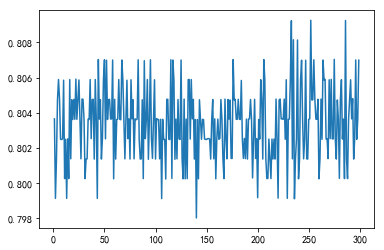

In [41]:
#random_state学习曲线
score = []
for i in range(1,300):
    clf = DecisionTreeClassifier(random_state=i,criterion='entropy',max_depth=8)
    score.append(cross_val_score(clf,titanic_train_data_X,titanic_train_data_Y,cv=10).mean())

print(max(score),score.index(max(score)))
plt.plot(np.arange(1,300),score)

0.8238034842810122 2


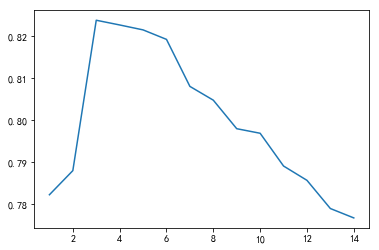

In [43]:
#max_depth学习曲线
score = []
for i in range(1,15):
    clf = DecisionTreeClassifier(random_state=0,criterion='entropy',max_depth=i)
    score.append(cross_val_score(clf,titanic_train_data_X,titanic_train_data_Y,cv=10).mean())

print(max(score),score.index(max(score)))
plt.plot(np.arange(1,15),score)

0.8293842923618204 1


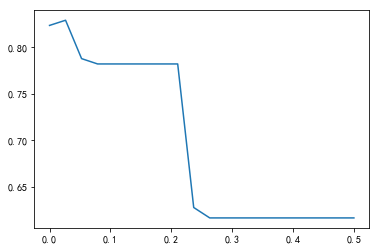

In [52]:
#最小信息增益min_impurity_decrease
score = []
for i in np.linspace(0,0.5,20):
    clf = DecisionTreeClassifier(random_state=252,criterion='entropy',max_depth=3,min_impurity_decrease=i)
    score.append(cross_val_score(clf,titanic_train_data_X,titanic_train_data_Y,cv=10).mean())

print(max(score),score.index(max(score)))
plt.plot(np.linspace(0,0.5,20),score)


In [58]:
#预测结果
clf = DecisionTreeClassifier(random_state=252,criterion='entropy',max_depth=3)
clf.fit(titanic_train_data_X,titanic_train_data_Y)
predictions = clf.predict(titanic_test_data_X)

StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv('DecisionTreeClassifier.csv',index=False,sep=',')

#### 融合模型精确率为76%，单一模型精确率为77%
#### 分析原因可能是因为融合模型中超参数设置不是最优，需调优后在融合
#### 发现在数据处理的思路方面还是有较大的欠缺。一味追求使用强学习模型并不一定能取得更好的结果，做好数据预处理与特征选择才是王道。

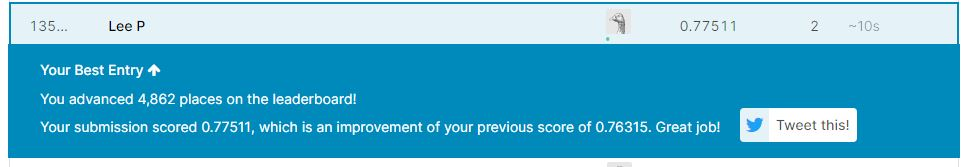

In [56]:
from IPython.display import Image
Image(filename = './DecisionTreeClassifier.JPG', width=1000, height=800)